In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"

from utils import get_hdf_keys
from train import training
from evaluation import evaluate, get_run_results
import warnings
import pickle
warnings.filterwarnings('ignore')
# Set seed
np.random.seed(42)

In [2]:
# Set working directory
import wandb
wandb.login()

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')
model_dir = os.path.join(os.getcwd(), 'models')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
locations_dict, resolutions_dict = get_hdf_keys(dir_path)

In [4]:
locations_dict

{'1_county.h5': ['Los_Angeles', 'New_York', 'Sacramento'],
 '2_town.h5': ['town_0', 'town_1', 'town_2'],
 '3_village.h5': ['village_0', 'village_1', 'village_2'],
 '4_neighborhood.h5': ['neighborhood_0', 'neighborhood_1', 'neighborhood_2'],
 '5_building.h5': ['building_0', 'building_1', 'building_2']}

### Loop through all locations and resolutions

In [ ]:
for scale, locations in locations_dict.items():

    scale = scale.split('.')[0]
    for location in locations:

        print(f"Training {location} at {scale} scale")
        config, models = training(scale, location) # loads existing models (from disk) if they exist, otherwise trains new models with optimial hyperparameters (from wandb) if they exist
        eval_dict = evaluate(config, models) # loads existing run results (from wandb) if they exist, otherwise runs a backtest for each model on the val and test set, and then formats it into the various horizons
        df_metrics = get_run_results(eval_dict, config) # calculates the error scores and produces plots, logging them to wandb if possible

        wandb.finish()

### Run for a single location

Training Los_Angeles at 1_county scale


wandb: Sorting runs by +summary_metrics.eval_loss


Fetched sweep with name deep-sweep-14 for model lgbm


Getting model instance for lgbm...
{'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 10, 'objective': 'reg:pseudohubererror', 'reg_lambda': 1, 'datetime_encodings': 0}
Getting model instance for linear regression...
Directory already exists: c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models
Directory already exists: c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models\1_county_Los_Angeles
c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models
Directory already exists: c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models\1_county_Los_Angeles
c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models


`enable_optimization=True` is ignored because `forecast_horizon > self.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Testing on Winter data
Generating historical forecasts with LightGBMModel


  0%|          | 0/697 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > self.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Generating historical forecasts with LinearRegressionModel


  0%|          | 0/697 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > self.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Testing on Summer data
Generating historical forecasts with LightGBMModel


  0%|          | 0/697 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > self.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Generating historical forecasts with LinearRegressionModel


  0%|          | 0/697 [00:00<?, ?it/s]

Calculating error metrics
Plotting side-by-side comparison of predictions and the ground truth
Plotting error metric trajectory
Plotting error distribution
Plotting daily sum of the predictions and the ground truth


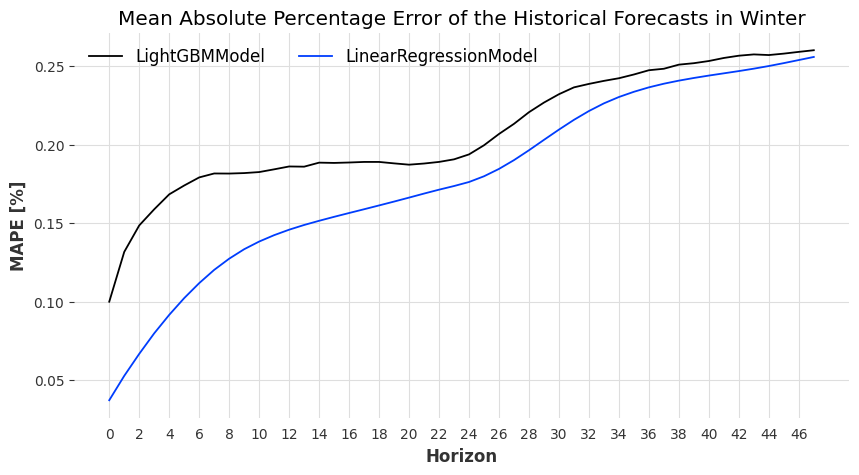

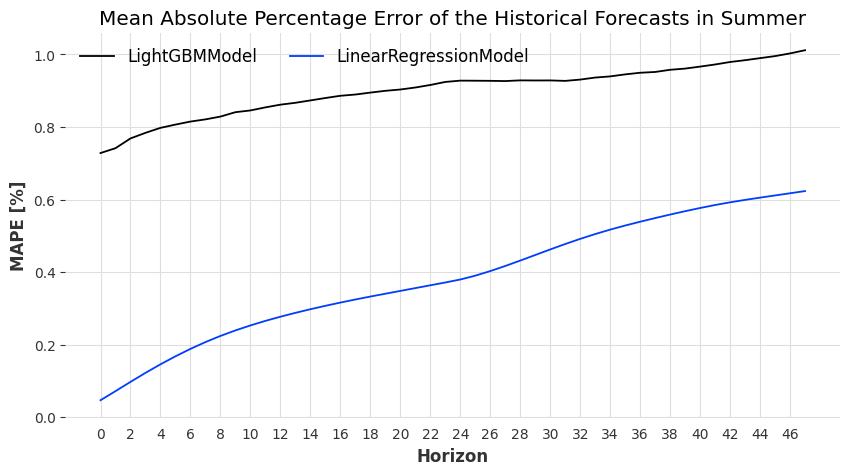

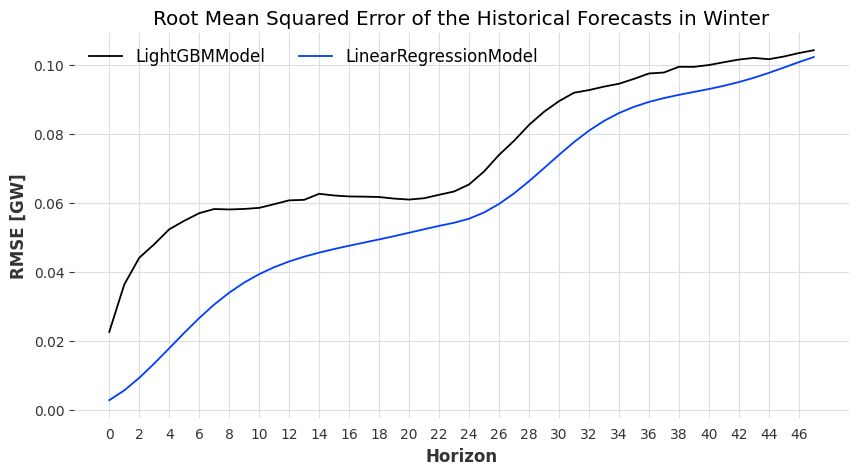

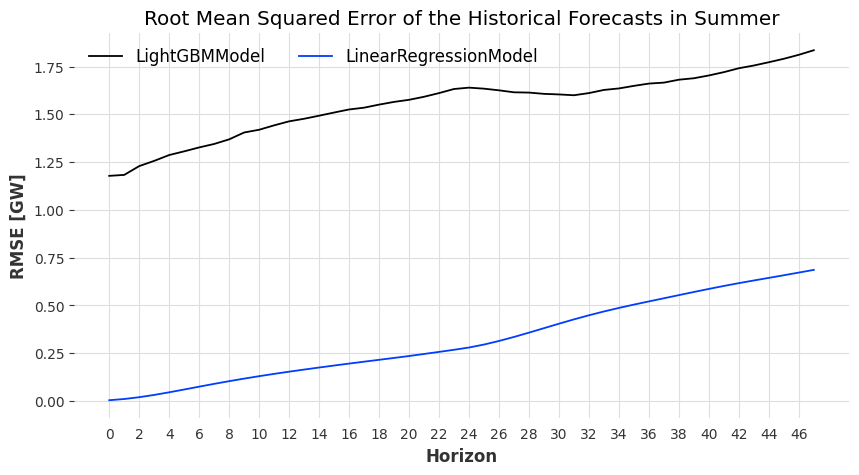

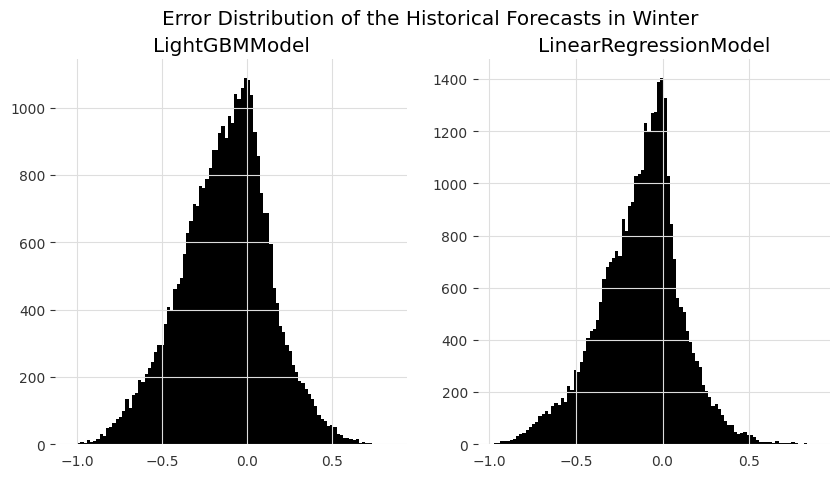

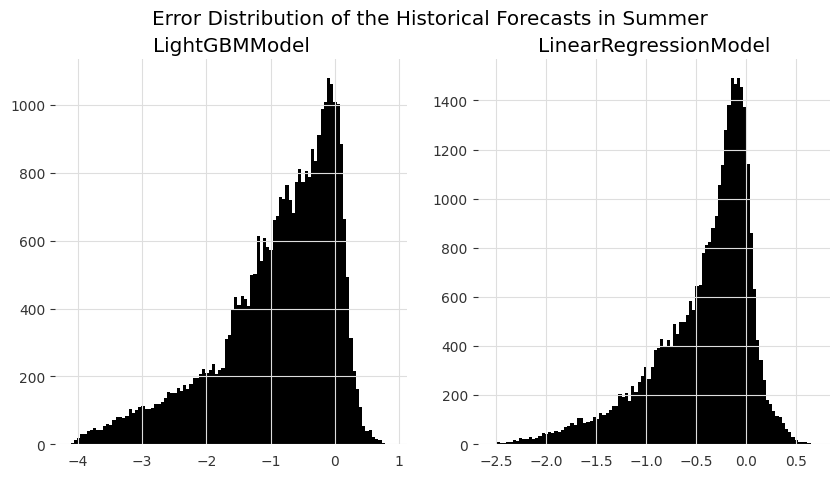

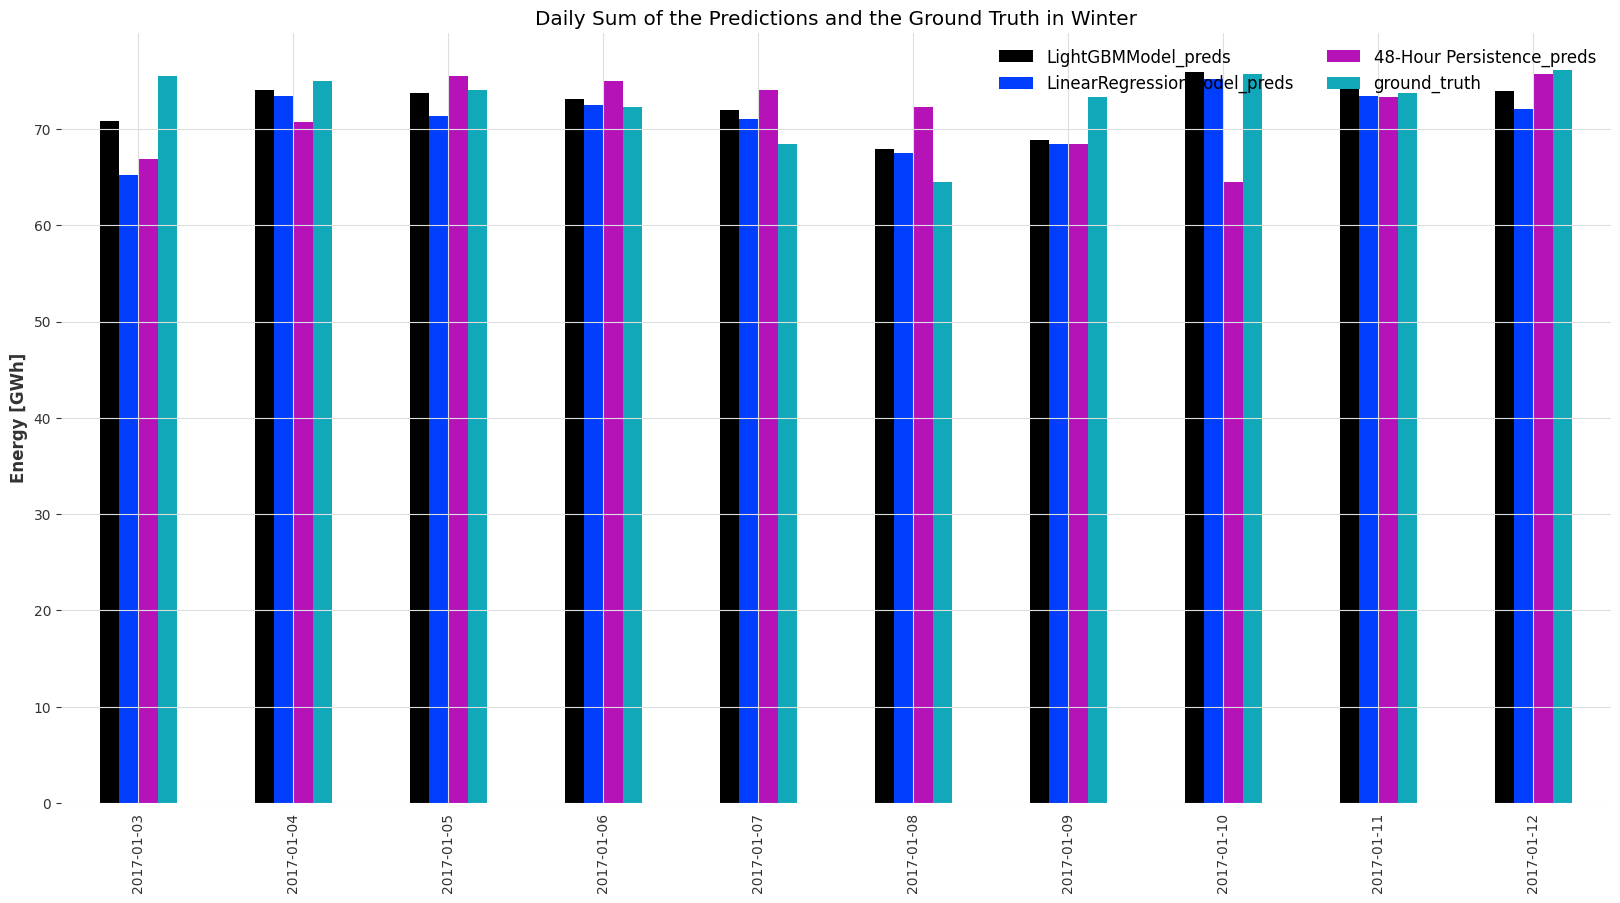

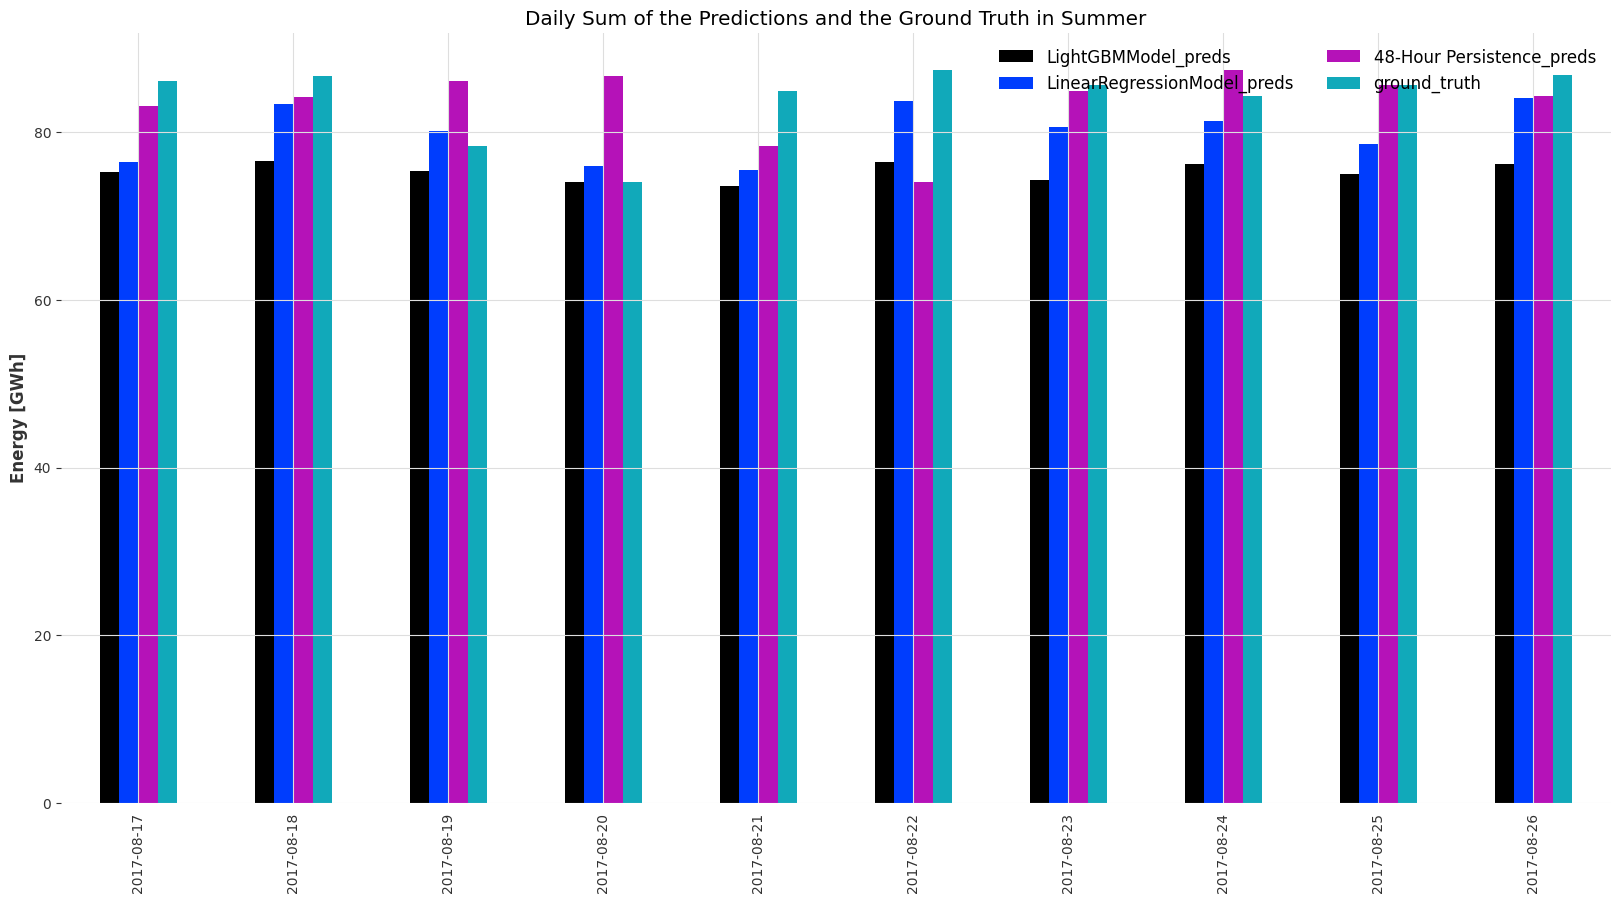

In [6]:
scale = '1_county'
location = 'Los_Angeles'

print(f"Training {location} at {scale} scale")

config, models = training(scale, location)

eval_dict = evaluate(config, models)

df_metrics = get_run_results(eval_dict, config)

wandb.finish()

## Debugging

In [ ]:
# dump and import eval dict from pickle

# with open('data/eval_dict.pkl', 'wb') as f:
#     pickle.dump(eval_dict, f)

with open('data/eval_dict.pkl', 'rb') as f:
    d = pickle.load(f)

df_metrics = get_run_results(d, config)

In [ ]:
from darts.models import LightGBMModel
m = LightGBMModel(input_chunk_length=24, lags_past_covariates=24, output_chunk_length=24, random_seed=42, **{'objective': 'huber'})

In [ ]:
from train import get_best_run_config, Config, data_pipeline


scale = '1_county'
location = 'Los_Angeles'
units_dict = {"county": "GW", "town": "MW", "village": "kW", "neighborhood": "kW"}

tuned_models = [
    # "rf",
    "lgbm",
    # "xgb",
    # "gru",
    # "nbeats",
    #'tft'
]

resolution = 60

config_per_model = {}
for model in tuned_models:
    config, name = get_best_run_config(
        "Wattcast_tuning", "+eval_loss", model, scale, location
    )
    print(f"Fetched sweep with name {name} for model {model}")
    config["horizon_in_hours"] = 48  # type: ignore
    config["location"] = location  # type: ignore
    config_per_model[model] = config, name

name_id = scale + "_" + location + "_" + str(resolution) + "min"
wandb.init(project="Wattcast", name=name_id, id=name_id)

config = Config().from_dict(config_per_model[tuned_models[0]][0])

(
    pipeline,
    ts_train_piped,
    ts_val_piped,
    ts_test_piped,
    ts_train_weather_piped,
    ts_val_weather_piped,
    ts_test_weather_piped,
    trg_train_inversed,
    trg_val_inversed,
    trg_test_inersed,
) = data_pipeline(config)




In [ ]:
m.fit(ts_train_piped, ts_train_weather_piped, verbose=True)

In [ ]:
import lightgbm as lgb